<a href="https://colab.research.google.com/github/ZikrullaRaxmatov/AI_Pytorch_Keras/blob/main/Melanoma_Skin_Care_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/melanoma_datasets.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing libraries
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt

In [3]:
#Loading datasets
train_dir = './melanoma_cancer_dataset/train/'
test_dir = './melanoma_cancer_dataset/test/'

#defining dimensions of images and batch size
img_width, img_height = 150, 150
batch_size = 64

#data argumentation with train dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.495, 0.455, 0.432],
                         std=[0.299, 0.225, 0.256])

])

#no data argumentation test/validation dataset
test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.495, 0.455, 0.432],
                         std=[0.299, 0.225, 0.256])

])

#Preparing/Processing dataset
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
#Creating a model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.fc_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 512),
        nn.ReLU(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is working with '{device}'")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Model is working with 'cuda'


In [5]:
#Training the model
#optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
best_accuracy = 0.0

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs.squeeze(), labels.float())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  #validation
  model.eval()
  total_samples = 0
  total_corrects = 0
  with torch.no_grad():
    for imgs, labs in test_loader:
      imgs, labs = imgs.to(device), labs.to(device)
      outs = model(imgs)
      predicted = (outs > 0.5).float()
      total_corrects += (predicted == labs.unsqueeze(1).float()).sum().item()
      total_samples += labs.size(0)

      epoch_loss = running_loss / len(train_loader)
      accuracy = total_corrects / total_samples

      train_losses.append(epoch_loss)
      train_accuracies.append(accuracy)

      print(f"Epoch [{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}]")



      if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Model impruved from {best_accuracy} to {accuracy}")


Epoch [1/15, Loss: 0.4281, Accuracy: 0.8281]
Model impruved from 0.828125 to 0.828125
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8281]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8542]
Model impruved from 0.8541666666666666 to 0.8541666666666666
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8750]
Model impruved from 0.875 to 0.875
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8906]
Model impruved from 0.890625 to 0.890625
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8854]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8862]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8789]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8542]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8609]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8722]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8828]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8894]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8906]
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8927]
Model impruved from 0.8927083333333333 to 0.8927083333333333
Epoch [1/15, Loss: 0.4281, Accuracy: 0.8700]
Epoch [2/15, Loss: 0.3573, Accuracy: 0.60

In [6]:
#Load the model
best_model = CNN()
best_model.load_state_dict(torch.load('best_model.pt'))

#Evaluate the model
total_samples = 0
total_corrects = 0
with torch.no_grad():
  for imgs, labs in test_loader:
    imgs, labs = imgs.to(device), labs.to(device)
    outs = model(imgs)
    predicted = (outs > 0.5).float()
    total_corrects += (predicted == labs.unsqueeze(1).float()).sum().item()
    total_samples += labs.size(0)

test_accuracy = total_corrects / total_samples
print(f"Accuracy: {test_accuracy * 100:.2f}%")


<ipython-input-6-693b6a95cac8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pt'))


Accuracy: 91.00%


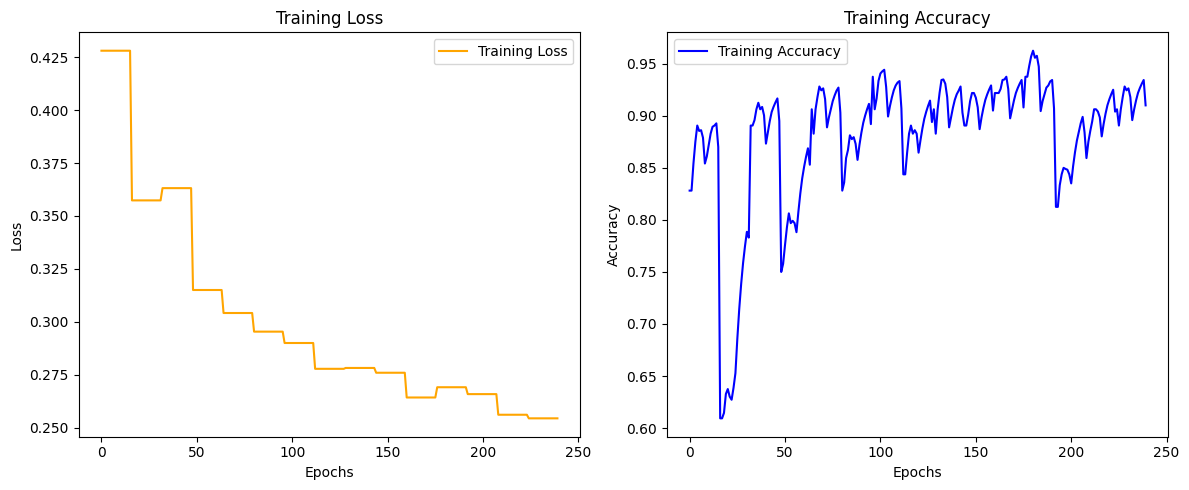

In [7]:
#Visualising the training model
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color="orange")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", color="Blue")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
